In [1]:
# Imports
%load_ext autoreload
%autoreload 2
import os
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from dataloaders.bouncing_data import BouncingBallDataLoader
from utils.losses import kld_loss, nll_gaussian, mse_through_time
from models.VRNN import VRNN
import warnings
warnings.filterwarnings('ignore')

In [2]:
torch.cuda.get_device_properties(0).total_memory

11554717696

## Load data/sample

In [26]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_convex_shape_colour_test_T=300/test', False, True)
train_loader = torch.utils.data.DataLoader(dl, batch_size=16, shuffle=True)
im, bck = next(iter(train_loader))
print(im.size())

torch.Size([16, 200, 3, 32, 32])


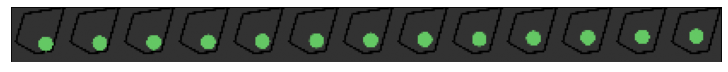

In [29]:
plt.figure(figsize=(10,10), constrained_layout=True)
#plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
plt.imshow(np.concatenate(im.permute(0,1,3,4,2)[0,:26:2].detach().cpu().numpy(), axis=1))
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
#plt.savefig("bouncing_ball_convex.pdf")

TypeError: Invalid shape (200, 32, 96) for image data

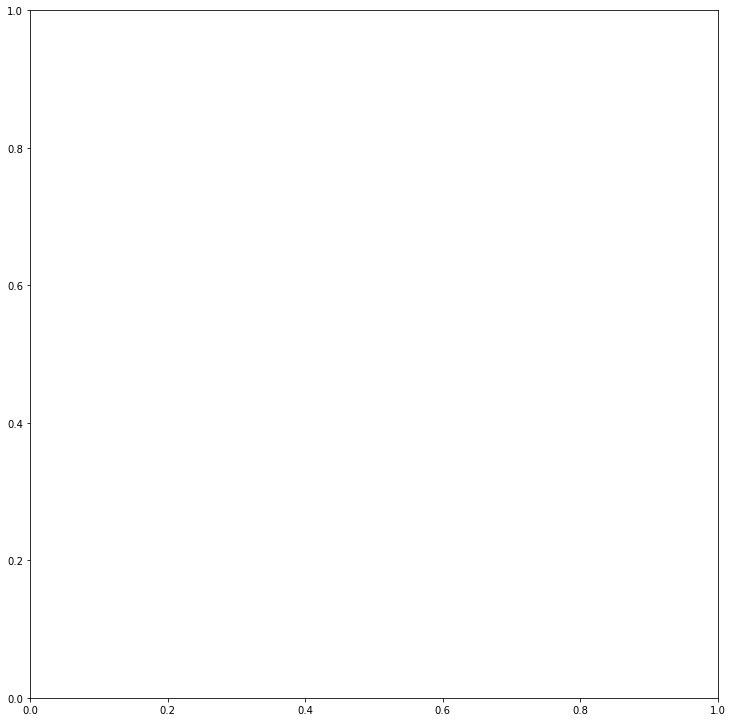

In [19]:
plt.figure(figsize=(10,10), constrained_layout=True)
plt.imshow(np.concatenate(im[0,:40:4,0].detach().cpu().numpy(), axis=1))
plt.xticks([])
plt.yticks([])
plt.autoscale(False)
plt.savefig("bouncing_ball_convex.pdf")

## Pos

### Load model

In [11]:
vrnn = VRNN(3, 2, 256, 64, num_rec_layers=3, input_type='base').float()
print(vrnn)
checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_pos_conditional_prior_box_lstm_big_latest.pth.tar', map_location=torch.device('cpu'))
vrnn.load_state_dict(checkpoint['vrnn'])

VRNN(
  (prior): MLP(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (embedder_x): MLP(
    (fc1): Linear(in_features=2, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): MLP(
    (fc1): Linear(in_features=320, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=2, bias=True)
  )
  (encoder): MLP(
    (fc1): Linear(in_features=320, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (embedder_z): MLP(
    (fc1): Linear(in_features=64, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out

<All keys matched successfully>

### Seq Autoencode

tensor(3.9346e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)

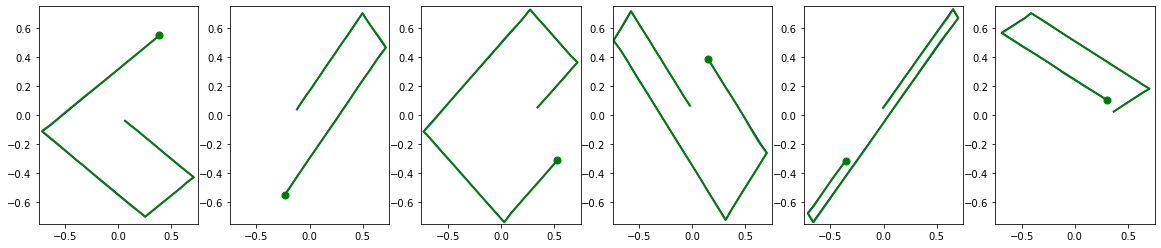

In [5]:
reconstr, _, _ = vrnn(pos[:,:50].float())
print(reconstr.size())
plt.figure(figsize=(20,4))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.plot(pos[i,:50,0].detach(),pos[i,:50,1].detach(), 'b')
    plt.plot(reconstr[i,:50,0].detach(),reconstr[i,:50,1].detach(), 'g', linewidth=2)
    plt.scatter(reconstr[i,-1,0].detach(),reconstr[i,-1,1].detach(), s=50,c='g')
    plt.xlim(-0.75,0.75)
    plt.ylim(-0.75,0.75)
F.mse_loss(reconstr,pos[:,:50])

### Seq prediction

In [6]:
T=50
pred_pos = vrnn.predict_sequence(pos[:,:50].float(),seq_len=T)
print(pred_pos.size())
target_pos = pos[:,50:50+T].float().to(pred_pos.device)
pred_mse = F.mse_loss(pred_pos, target_pos)
print(pred_mse)

torch.Size([16, 50, 2])
tensor(0.0058, grad_fn=<MseLossBackward>)


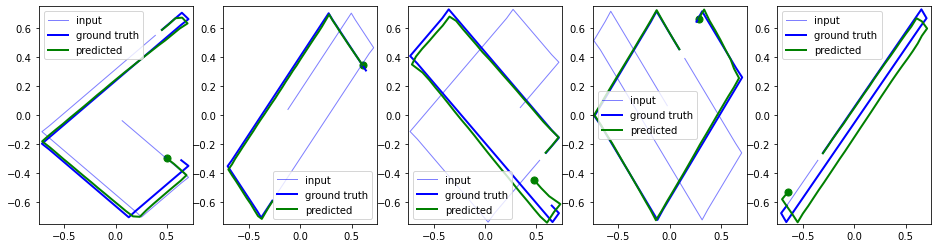

In [7]:
plt.figure(figsize=(16,4))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.plot(pos[i,50-T:50,0].detach(),pos[i,50-T:50,1].detach(), 'b', linewidth=1, alpha=0.5, label='input')
    plt.plot(pos[i,50:50 + T,0].detach(),pos[i,50:50 + T,1].detach(), 'b', linewidth=2, alpha=1, label='ground truth')
    plt.plot(pred_pos[i,:T,0].detach(),pred_pos[i,:T,1].detach(), 'g', linewidth=2, label='predicted')
    plt.scatter(pred_pos[i,-1,0].detach(),pred_pos[i,-1,1].detach(), s=50,c='g')
    plt.xlim(-0.75,0.75)
    plt.ylim(-0.75,0.75)
    plt.legend()

### Seq Generation

In [9]:
b = 16
h_prev = torch.zeros((3, b, vrnn.hidden_dim))
c_prev = torch.zeros((3, b, vrnn.hidden_dim))
pred_seq = torch.zeros((b, 100, 2))
for i in range(50):
    z_sampled = vrnn._sample(h_prev)
    x_hat, h_prev, c_prev = vrnn._decode(z_sampled, h_prev, c_prev)
    pred_seq[:,i,:] = x_hat

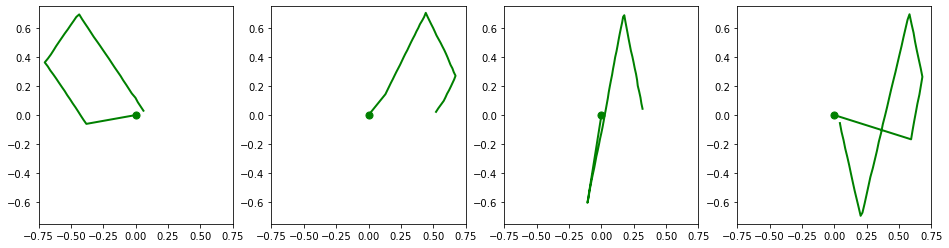

In [10]:
plt.figure(figsize=(16,4))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(pred_seq[i,:100,0].detach(),pred_seq[i,:100,1].detach(), 'g', linewidth=2)
    plt.scatter(pred_seq[i,-1,0].detach(),pred_seq[i,-1,1].detach(), s=50,c='g')
    plt.xlim(-.75,.75)
    plt.ylim(-.75,.75)

## Image

### Load model

In [17]:
vrnn = VRNN(3, 2, 256, 64, num_rec_layers=3, input_type='visual').float()
print(vrnn)
checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_visual_square_beta_0_005_latest.pth.tar', map_location=torch.device('cpu'))
vrnn.load_state_dict(checkpoint['vrnn'])

VRNN(
  (prior): MLP(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=128, bias=True)
  )
  (embedder_x): CNNEncoder(
    (in_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (out_mean): MLP(
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc_final): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (decoder

<All keys matched successfully>

### Sequence Autoencode

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


torch.Size([16, 50, 3, 32, 32])
tensor(5.3856e-06, dtype=torch.float64, grad_fn=<MseLossBackward>)


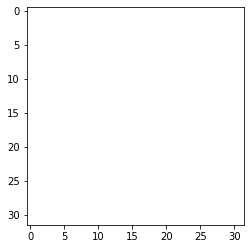

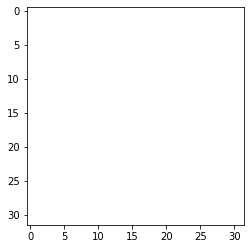

In [18]:
reconstr, _, _ = vrnn(im[:,:50].float())
print(reconstr.size())
print(F.mse_loss(reconstr,im[:,:50]))
reconstr = reconstr.detach().numpy().transpose((0,1,4,3,2))
im_np = im.detach().numpy().transpose((0,1,4,3,2))
def get_frames(frames_np):
    fig, ax = plt.subplots()
    ims = []
    for i in range(50):
        im_ax = ax.imshow(frames_np[i], animated=True)
        ims.append([im_ax])
    return fig, ims
fig_pred, ims_pred = get_frames(reconstr[0])
ani_pred = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
fig_true, ims_true = get_frames(im_np[0])
ani_true = animation.ArtistAnimation(fig_true, ims_true, interval=50, blit=True,
                                repeat_delay=1000)

In [19]:
HTML(ani_pred.to_html5_video())

In [21]:
HTML(ani_true.to_html5_video())

### Sequence Prediction

torch.Size([16, 50, 3, 32, 32])
tensor(0.0011, grad_fn=<MseLossBackward>)


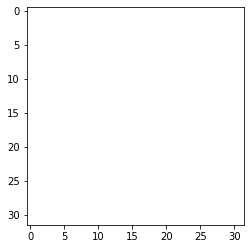

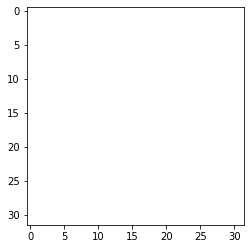

In [23]:
T=50
pred_ = vrnn.predict_sequence(im[:,:50].float(),seq_len=T)
print(pred_.size())
target_ = im[:,50:50+T].float().to(pred_.device)
pred_mse = F.mse_loss(pred_, target_)
print(pred_mse)
fig_pred, ims_pred = get_frames(pred_[10].detach().numpy().transpose((0,3,2,1)))
ani_pred = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
fig_true, ims_true = get_frames(target_[10].detach().numpy().transpose((0,3,2,1)))
ani_true = animation.ArtistAnimation(fig_true, ims_true, interval=50, blit=True,
                                repeat_delay=1000)

In [24]:
HTML(ani_pred.to_html5_video())

In [25]:
HTML(ani_true.to_html5_video())

### Sequence Sampling

In [26]:
b = 1
h_prev = torch.zeros((3, b, vrnn.hidden_dim))
c_prev = torch.zeros((3, b, vrnn.hidden_dim))
pred_seq = torch.zeros((b, 50, 3, 32, 32))
for i in range(50):
    z_sampled = vrnn._sample(h_prev)
    x_hat, h_prev, c_prev = vrnn._decode(z_sampled, h_prev, c_prev)
    pred_seq[:,i,:] = x_hat

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


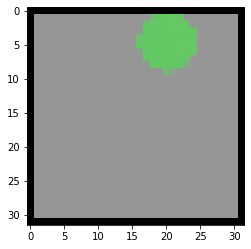

In [27]:
fig_pred, ims_pred = get_frames(pred_seq[0].detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani_sample.to_html5_video())

## Convex shape

In [2]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data/train', False)
train_loader = torch.utils.data.DataLoader(dl, batch_size=16, shuffle=True)
im, pos = next(iter(train_loader))
print(im.size(), pos.size())

torch.Size([16, 100, 3, 32, 32]) torch.Size([16, 100, 2])


### Load Model

In [3]:
vrnn = VRNN(3, 2, 256, 128, num_rec_layers=3, input_type='visual').float()
print(vrnn)
checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_b_back_beta_1_e-1_128_latest.pth.tar', map_location=torch.device('cpu'))
vrnn.load_state_dict(checkpoint['vrnn'])

VRNN(
  (prior): MLP(
    (fc1): Linear(in_features=256, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc_final): Linear(in_features=256, out_features=256, bias=True)
  )
  (embedder_x): CNNEncoder(
    (in_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (hidden_conv): ModuleList(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (out_mean): MLP(
      (fc1): Linear(in_features=256, out_features=128, bias=True)
      (fc2): Linear(in_features=128, out_features=128, bias=True)
      (fc_final): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (decode

<All keys matched successfully>

### Autoencode

torch.Size([16, 50, 3, 32, 32])
tensor(0.0003, dtype=torch.float64, grad_fn=<MseLossBackward>)


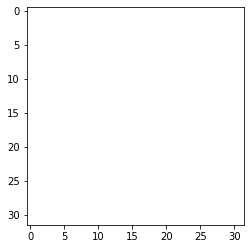

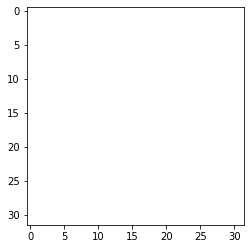

In [4]:
reconstr, _, _ = vrnn(im[:,:50].float())
print(reconstr.size())
print(F.mse_loss(reconstr,im[:,:50]))
reconstr = reconstr.detach().numpy().transpose((0,1,4,3,2))
im_np = im.detach().numpy().transpose((0,1,4,3,2))
def get_frames(frames_np):
    fig, ax = plt.subplots()
    ims = []
    for i in range(50):
        im_ax = ax.imshow(frames_np[i], animated=True)
        ims.append([im_ax])
    return fig, ims
fig_pred, ims_pred = get_frames(reconstr[0])
ani_pred = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
fig_true, ims_true = get_frames(im_np[0])
ani_true = animation.ArtistAnimation(fig_true, ims_true, interval=50, blit=True,
                                repeat_delay=1000)

In [5]:
HTML(ani_pred.to_html5_video())

In [6]:
HTML(ani_true.to_html5_video())

### Prediction

torch.Size([16, 50, 3, 32, 32])
tensor(0.0086, grad_fn=<MseLossBackward>)


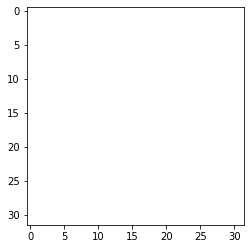

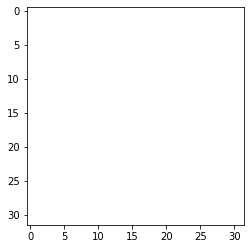

In [10]:
T=50
b=1
pred_ = vrnn.predict_sequence(im[:,:50].float(),seq_len=T)
print(pred_.size())
target_ = im[:,50:50+T].float().to(pred_.device)
pred_mse = F.mse_loss(pred_, target_)
print(pred_mse)
fig_pred, ims_pred = get_frames(pred_[b].detach().numpy().transpose((0,3,2,1)))
ani_pred = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
fig_true, ims_true = get_frames(target_[b].detach().numpy().transpose((0,3,2,1)))
ani_true = animation.ArtistAnimation(fig_true, ims_true, interval=50, blit=True,
                                repeat_delay=1000)

In [11]:
HTML(ani_pred.to_html5_video())

In [12]:
HTML(ani_true.to_html5_video())

### Sampling

In [16]:
b = 1
h_prev = torch.zeros((3, b, vrnn.hidden_dim))
c_prev = torch.zeros((3, b, vrnn.hidden_dim))
pred_seq = torch.zeros((b, 50, 3, 32, 32))
for i in range(50):
    z_sampled = vrnn._sample(h_prev)
    x_hat, h_prev, c_prev = vrnn._decode(z_sampled, h_prev, c_prev)
    pred_seq[:,i,:] = x_hat

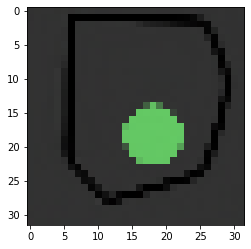

In [17]:
fig_pred, ims_pred = get_frames(pred_seq[0].detach().numpy().transpose((0,3,2,1)))
ani_sample = animation.ArtistAnimation(fig_pred, ims_pred, interval=50, blit=True,
                                repeat_delay=1000)
HTML(ani_sample.to_html5_video())

### MSE through time

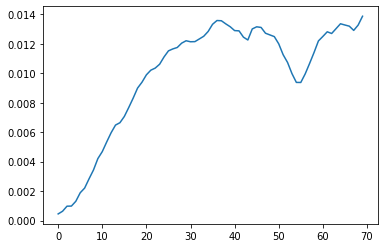

In [20]:
T=70
pred_ = vrnn.predict_sequence(im[:,:30].float(),seq_len=T)
target_ = im[:,30:30+T].float().to(pred_.device)
pred_mse = F.mse_loss(pred_, target_)
mse_t_t = mse_through_time(pred_, target_).cpu().detach().numpy()
plt.plot(range(T),mse_t_t)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


  0%|          | 0/32 [00:00<?, ?it/s]

/data2/packages/anaconda3/envs/py38_pytorch/lib/python3.8/site-packages/torch/nn/functional.py:3825: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


KeyboardInterrupt: 

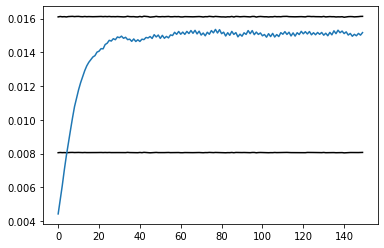

In [4]:
%load_ext autoreload
%autoreload 2
import os
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from dataloaders.bouncing_data import BouncingBallDataLoader
from utils.losses import kld_loss, nll_gaussian, mse_through_time
from models.VRNN import VRNN
import warnings
with torch.no_grad():
    T=150
    models = [
        '5',
        '1',
        '5_e-1',
        '1_e-1',
        '5_e-2',
        '1_e-2',
        '5_e-3_2',
        '1_e-3',
    ]
    labels = [
        '5',
        '1',
        '5e-1',
        '1e-1',
        '5e-2',
        '1e-2',
        '5e-3',
        '1e-3'
    ]
    fig = plt.figure()
    dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_convex_shape_colour_test_T=300/test', False, True)
    train_loader = torch.utils.data.DataLoader(dl, batch_size=32, shuffle=True)
    mse_t_t_list = np.empty((150,0))
    for im, bck in tqdm(train_loader):
        target_ = im[:,50:50+T].float().cuda()
        pred_ = bck[:,50:50+T].float().cuda()
        mse_t_t = mse_through_time(pred_, target_, reduce=False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(T),mse_t_t, label='Background', color='k')
    plt.plot(range(T),2*mse_t_t, label='Backgroundx2', color='k')
    dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_convex_shape_colour_test_T=300/test', False)
    train_loader = torch.utils.data.DataLoader(dl, batch_size=32, shuffle=True)
    for i in tqdm(range(len(models))):
        vrnn = VRNN(3, 2, 256, 128, num_rec_layers=3, input_type='visual').float().cuda()
        checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_b_back_beta_' + models[i] + '_128_latest.pth.tar')#, map_location=torch.device('cpu'))
        vrnn.load_state_dict(checkpoint['vrnn'])
        T=150
        mse_t_t_list = np.empty((150,0))
        for im in tqdm(train_loader):
            pred_ = vrnn.predict_sequence(im[:,:50].float().cuda(),seq_len=T)
            target_ = im[:,50:50+T].float().to(pred_.device)
            mse_t_t = mse_through_time(pred_, target_, reduce=False).cpu().detach().numpy()
            mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
        mse_t_t = mse_t_t_list.mean(axis=1)
        plt.plot(range(T),mse_t_t, label=r'$\beta$='+ labels[i])
    plt.xlabel('Time')
    plt.ylabel('MSE')
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    plt.legend()
    plt.savefig("mse_throught_time_convex_vrnn.pdf")

  0%|          | 0/2 [00:00<?, ?it/s]

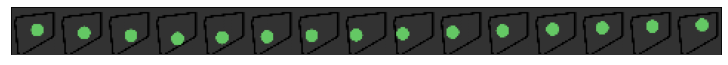

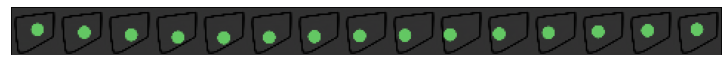

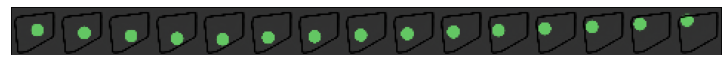

In [20]:
dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_convex_shape_colour_test_T=300/test', False, True)
train_loader = torch.utils.data.DataLoader(dl, batch_size=32, shuffle=True)
with torch.no_grad():
    im = next(iter(train_loader))[0]
    models = [
        '5_e-1',
        '5_e-3'
    ]
    T=45
    target_ = im[:,50:50+T].float().cuda()
    plt.figure(figsize=(10,10), constrained_layout=True)
    #plt.imshow(im.permute(0,1,3,4,2)[0,0,].detach().cpu().numpy())
    plt.imshow(np.concatenate(target_[:,:].permute(0,1,3,4,2)[0,::3].detach().cpu().numpy(), axis=1), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.autoscale(False)
    plt.savefig('convex_bouncing_ball_viz_groundtruth.png',dpi=300)

    for i in tqdm(range(len(models))):
        vrnn = VRNN(3, 2, 256, 128, num_rec_layers=3, input_type='visual').float().cuda()
        checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_b_back_beta_' + models[i] + '_128_latest.pth.tar')#, map_location=torch.device('cpu'))
        vrnn.load_state_dict(checkpoint['vrnn'])
        T=45
        mse_t_t_list = np.empty((150,0))
        pred_ = vrnn.predict_sequence(im[:,:50].float().cuda(),seq_len=T)
        plt.figure(figsize=(10,10), constrained_layout=True)

        plt.imshow(np.concatenate(pred_[:,:].permute(0,1,3,4,2)[0,::3].detach().cpu().numpy(), axis=1))
        plt.xticks([])
        plt.yticks([])
        plt.autoscale(False)
        plt.savefig('convex_bouncing_ball_viz_vrnn' + str(models[i]) + '.png',dpi=300)

In [10]:
with torch.no_grad():
    dl = BouncingBallDataLoader('/data2/users/cb221/bouncing_ball_data_long/test', False)
    train_loader = torch.utils.data.DataLoader(dl, batch_size=32, shuffle=True)
    im, pos = next(iter(train_loader))
    models = [
        '5',
        '1',
        '5_e-1',
        '1_e-1',
        '5_e-2',
        '1_e-2',
        '5_e-3_2',
        '1_e-3',
    ]
    fig = plt.figure()
    for i in tqdm(range(len(models))):
        vrnn = VRNN(3, 2, 256, 128, num_rec_layers=3, input_type='visual').float()
        checkpoint = torch.load('/data2/users/cb221/stored_models/VRNN_b_back_beta_' + models[i] + '_128_latest.pth.tar', map_location=torch.device('cpu'))
        vrnn.load_state_dict(checkpoint['vrnn'])
        T=150
        pred_ = vrnn.predict_sequence(im[:,:50].float(),seq_len=T)
        target_ = im[:,50:50+T].float().to(pred_.device)
        pred_mse = F.mse_loss(pred_, target_)
        mse_t_t = mse_through_time(pred_, target_).cpu().detach().numpy()
        plt.plot(range(T),mse_t_t, label=models[i])
    plt.legend()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data2/users/cb221/bouncing_ball_data_long/test'

  0%|          | 0/50 [00:00<?, ?it/s]

No handles with labels found to put in legend.


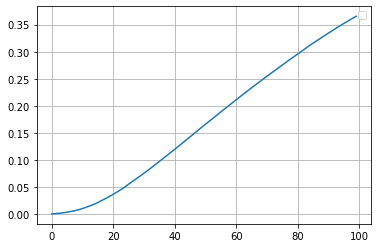

In [37]:
from dataloaders.nba_data import NBADataset
with torch.no_grad():
    dl = NBADataset('/data2/users/cb221/NBA_data_velocities_states/', '/data2/users/cb221/NBA_data_velocities_states_indices/indices_test_list.npy')
    train_loader = torch.utils.data.DataLoader(dl, batch_size=128, shuffle=True)
    fig = plt.figure()
    vrnn = VRNN(1, 40, 256, 128, num_rec_layers=3, input_type='base', ball_cond=True).float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_condbest_pred_latest.pth.tar')
    vrnn.load_state_dict(checkpoint['vrnn'])
    mse_t_t_list = np.empty((100,0))
    T=100
    for sample in tqdm(train_loader):
        B, _, _ , _ = sample.size()
        input = sample[:,:100,1:][:,:,:,[0,1,3,4]].cuda().reshape(B,T,-1)
        ball_coord = sample[:,:,0,:3].float().cuda()
        pred_ = vrnn.predict_sequence(input.cuda().float(), seq_len=T, ball_coord=ball_coord).reshape(B,T,10,4)
        target_ = sample[:,100:100+T,1:][:,:,:,[0,1,3,4]].float().to(pred_.device)
        pred_mse = F.mse_loss(pred_.reshape(B,T,10,4)[:,:,:,:2], target_[:,:,:,:2])
        mse_t_t = mse_through_time(pred_[:,:,:,:2], target_[:,:,:,:2], False).cpu().detach().numpy()
        mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
    mse_t_t = mse_t_t_list.mean(axis=1)
    plt.plot(range(T),mse_t_t)
    plt.legend()
    plt.grid()
    plt.show()

In [39]:
np.save('mse_through_time_VRNN_pos', mse_t_t)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

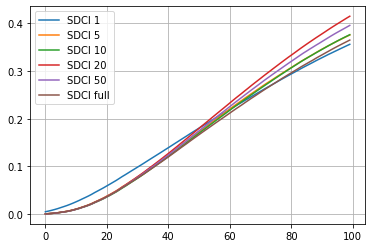

In [40]:
from dataloaders.nba_data import NBADataset
means_list = []
std_list = []
with torch.no_grad():
    dl = NBADataset('/data2/users/cb221/NBA_data_velocities_states/', '/data2/users/cb221/NBA_data_velocities_states_indices/indices_test_list.npy')
    train_loader = torch.utils.data.DataLoader(dl, batch_size=128, shuffle=True)
    fig = plt.figure()
    vrnn = VRNN(1, 40, 256, 128, num_rec_layers=3, input_type='base', ball_cond=True).float().cuda()
    paths = [
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_1best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_5best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_10best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_20best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_50best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_condbest_pred_latest.pth.tar',
    ]
    labels = [
        'SDCI_1',
        'SDCI_5',
        'SDCI_10',
        'SDCI_20',
        'SDCI_50',
        'SDCI_full'
    ]
    for path_i, label_i in zip(paths, labels):
        checkpoint = torch.load(path_i)
        vrnn.load_state_dict(checkpoint['vrnn'])
        mse_t_t_list = np.empty((100,0))
        T=100
        for sample in tqdm(train_loader):
            B, _, _ , _ = sample.size()
            input = sample[:,:100,1:][:,:,:,[0,1,3,4]].cuda().reshape(B,T,-1)
            ball_coord = sample[:,:,0,:3].float().cuda()
            pred_ = vrnn.predict_sequence(input.cuda().float(), seq_len=T, ball_coord=ball_coord).reshape(B,T,10,4)
            target_ = sample[:,100:100+T,1:][:,:,:,[0,1,3,4]].float().to(pred_.device)
            pred_mse = F.mse_loss(pred_.reshape(B,T,10,4)[:,:,:,:2], target_[:,:,:,:2])
            mse_t_t = mse_through_time(pred_[:,:,:,:2], target_[:,:,:,:2], False).cpu().detach().numpy()
            mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
        mse_t_t = mse_t_t_list.mean(axis=1)
        mse_t_t_means = mse_t_t_list.mean(axis=1)
        means_list.append(mse_t_t_means)
        mse_t_t_std = mse_t_t_list.std(axis=1)
        std_list.append(mse_t_t_std)
        plt.plot(range(T),mse_t_t, label=label_i.replace('_', ' '))
np.save('means_data_efficiency_NBA_VRNN',means_list)
np.save('std_data_efficiency_NBA_VRNN',std_list)
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

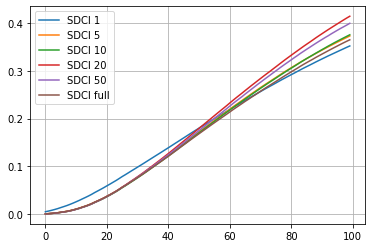

In [2]:
from dataloaders.nba_data import NBADataset
means_list = []
std_list = []
with torch.no_grad():
    dl = NBADataset('/data2/users/cb221/NBA_data_velocities_states/', '/data2/users/cb221/NBA_data_velocities_states_indices/indices_test_list.npy')
    train_loader = torch.utils.data.DataLoader(dl, batch_size=128, shuffle=True)
    fig = plt.figure()
    vrnn = VRNN(1, 40, 256, 128, num_rec_layers=3, input_type='base', ball_cond=True).float().cuda()
    paths = [
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_1best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_5best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_10best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_20best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_50best_pred_latest.pth.tar',
        '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_condbest_pred_latest.pth.tar',
    ]
    labels = [
        'SDCI_1',
        'SDCI_5',
        'SDCI_10',
        'SDCI_20',
        'SDCI_50',
        'SDCI_full'
    ]
    for path_i, label_i in zip(paths, labels):
        checkpoint = torch.load(path_i)
        vrnn.load_state_dict(checkpoint['vrnn'])
        mse_t_t_list = np.empty((100,0))
        T=100
        for sample in tqdm(train_loader):
            B, _, _ , _ = sample.size()
            input = sample[:,:100,1:][:,:,:,[0,1,3,4]].cuda().reshape(B,T,-1)
            ball_coord = sample[:,:,0,:3].float().cuda()
            pred_ = vrnn.predict_sequence(input.cuda().float(), seq_len=T, ball_coord=ball_coord).reshape(B,T,10,4)
            target_ = sample[:,100:100+T,1:][:,:,:,[0,1,3,4]].float().to(pred_.device)
            pred_mse = F.mse_loss(pred_.reshape(B,T,10,4)[:,:,:,:2], target_[:,:,:,:2])
            mse_t_t = mse_through_time(pred_[:,:,:,:2], target_[:,:,:,:2], False).cpu().detach().numpy()
            mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
        mse_t_t = mse_t_t_list.mean(axis=1)
        mse_t_t_means = mse_t_t_list.mean(axis=1)
        means_list.append(mse_t_t_means)
        mse_t_t_std = mse_t_t_list.std(axis=1)
        std_list.append(mse_t_t_std)
        plt.plot(range(T),mse_t_t, label=label_i.replace('_', ' '))
np.save('means_data_efficiency_NBA_VRNN',means_list)
np.save('std_data_efficiency_NBA_VRNN',std_list)
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/103 [00:00<?, ?it/s]

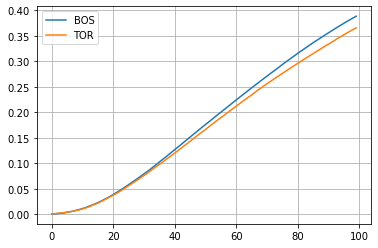

In [43]:
from dataloaders.nba_data import NBADataset
means_list = []
std_list = []
with torch.no_grad():
    datasets=['BOS','TOR']
    fig = plt.figure()
    vrnn = VRNN(1, 40, 256, 128, num_rec_layers=3, input_type='base', ball_cond=True).float().cuda()
    checkpoint = torch.load('/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_RAPTORSbest_pred_latest.pth.tar')
    vrnn.load_state_dict(checkpoint['vrnn'])
    T=100
    for dataset in datasets:
        dl = NBADataset('/data2/users/cb221/NBA_data_velocities_states_'+ dataset +'/', None)
        train_loader = torch.utils.data.DataLoader(dl, batch_size=128, shuffle=True)
        mse_t_t_list = np.empty((100,0))
        for sample in tqdm(train_loader):
            B, _, _ , _ = sample.size()
            input = sample[:,:100,1:][:,:,:,[0,1,3,4]].cuda().reshape(B,T,-1)
            ball_coord = sample[:,:,0,:3].float().cuda()
            pred_ = vrnn.predict_sequence(input.cuda().float(), seq_len=T, ball_coord=ball_coord).reshape(B,T,10,4)
            target_ = sample[:,100:100+T,1:][:,:,:,[0,1,3,4]].float().to(pred_.device)
            pred_mse = F.mse_loss(pred_.reshape(B,T,10,4)[:,:,:,:2], target_[:,:,:,:2])
            mse_t_t = mse_through_time(pred_[:,:,:,:2], target_[:,:,:,:2], False).cpu().detach().numpy()
            mse_t_t_list = np.concatenate((mse_t_t_list,mse_t_t),axis=-1)
        mse_t_t = mse_t_t_list.mean(axis=1)
        mse_t_t_means = mse_t_t_list.mean(axis=1)
        means_list.append(mse_t_t_means)
        mse_t_t_std = mse_t_t_list.std(axis=1)
        std_list.append(mse_t_t_std)
        plt.plot(range(T),mse_t_t, label=dataset)
    
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
T=100
vrnn = VRNN(1, 40, 256, 128, num_rec_layers=3, input_type='base', ball_cond=True).float().cuda()
path = '/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_condbest_pred_latest.pth.tar'
checkpoint = torch.load('/data2/users/cb221/stored_models_NBA_ICLR/VRNN_NBA_velocity_cond_RAPTORSbest_pred_latest.pth.tar')
vrnn.load_state_dict(checkpoint['vrnn'])
data = torch.from_numpy(np.load('/data2/users/cb221/video_causal_discovery/data_in.npy'))
input = data[:,:100,1:][:,:,:,[0,1,3,4]].cuda().reshape(24,T,-1)
ball_coord = data[:,:,0,:3].float().cuda()
pred_ = vrnn.predict_sequence(input.cuda().float(), seq_len=T, ball_coord=ball_coord).reshape(24,T,10,4)

In [10]:
np.save('pred_VRNN.npy', pred_.cpu().detach().numpy())